In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Configuración para que Pandas muestre las filas completas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# ==============================================================================
# 1. CARGA DE DATOS Y PREPARACIÓN DEL DATAFRAME (Limpieza y Conversión)
# ==============================================================================

# Se utiliza el archivo 'ultimo.xlsx - codigo.csv' que contiene las columnas IVS_codificado.
df = pd.read_excel('/content/ultimo.xlsx')

# Renombrar columnas clave para el análisis
df.rename(columns={
    'IVS': 'IVS_tasa_continua',
    'sintomas': 'sintomas',
    'espirometria_reducido': 'espirometria_reducida',
    'años_trabajando': 'años_trabajando',
    'IVS': 'IVS_codificado' # Columna IVS codificada 1, 2, 3
}, inplace=True)

# Asegurar tipos de datos correctos
df['años_trabajando'] = pd.to_numeric(df['años_trabajando'], errors='coerce')
df['sintomas'] = pd.to_numeric(df['sintomas'], errors='coerce').astype('Int64')
df['espirometria_reducida'] = pd.to_numeric(df['espirometria_reducida'], errors='coerce').astype('Int64')
df['IVS_codificado'] = pd.to_numeric(df['IVS_codificado'], errors='coerce').astype('Int64')

# Definición de variables clave
EXPOSURE_IVS = 'IVS_codificado' # Categórica/Ordinal (1, 2, 3)
EXPOSURE_AÑOS = 'años_trabajando' # Cuantitativa
OUTCOME_SINTOMAS = 'sintomas' # Dicotómica (0, 1)
OUTCOME_ESPIRO = 'espirometria_reducida' # Dicotómica (0, 1)


In [ ]:
# ==============================================================================
# 2. PRUEBAS ESTADÍSTICAS BIVARIADAS (VALOR P)
# ==============================================================================

print("\n--- 1. RESULTADOS DE VALOR P (4 PRUEBAS ESPECÍFICAS) ---")
results_p = []

def run_test(X_col, Y_col, test_type):
    """Función que ejecuta Chi-Cuadrada o Mann-Whitney U."""
    df_temp = df.dropna(subset=[X_col, Y_col])
    p_value = np.nan
    test_name = test_type

    if test_type == 'Chi-Cuadrada':
        contingency = pd.crosstab(df_temp[X_col], df_temp[Y_col])
        # Usamos Chi-Cuadrada para tablas 3x2 (IVS vs. Outcomes)
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            try:
                chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
            except:
                pass # P-value queda como NaN si falla el cálculo

    elif test_type == 'Mann-Whitney U':
        group_0 = df_temp[df_temp[Y_col] == 0][X_col]
        group_1 = df_temp[df_temp[Y_col] == 1][X_col]
        if len(group_0) > 1 and len(group_1) > 1:
            try:
                _, p_value = mannwhitneyu(group_0.astype(float), group_1.astype(float), method='exact')
            except:
                pass

    return p_value, test_name

# Ejecutar las 4 combinaciones
combinations = [
    (EXPOSURE_IVS, OUTCOME_ESPIRO, 'Chi-Cuadrada'), # IVS vs. Espiro
    (EXPOSURE_IVS, OUTCOME_SINTOMAS, 'Chi-Cuadrada'), # IVS vs. Síntomas
    (EXPOSURE_AÑOS, OUTCOME_ESPIRO, 'Mann-Whitney U'), # Años vs. Espiro
    (EXPOSURE_AÑOS, OUTCOME_SINTOMAS, 'Mann-Whitney U') # Años vs. Síntomas
]

for X, Y, test in combinations:
    p_val, test_used = run_test(X, Y, test)
    results_p.append({'Exposición': X, 'Desenlace': Y, 'Prueba': test_used, 'Valor p': f"{p_val:.4f}"})

df_p = pd.DataFrame(results_p)
print(df_p)


--- 1. RESULTADOS DE VALOR P (4 PRUEBAS ESPECÍFICAS) ---
        Exposición              Desenlace          Prueba Valor p
0   IVS_codificado  espirometria_reducida    Chi-Cuadrada  0.7668
1   IVS_codificado               sintomas    Chi-Cuadrada  0.1722
2  años_trabajando  espirometria_reducida  Mann-Whitney U  0.3702
3  años_trabajando               sintomas  Mann-Whitney U  0.0394


In [ ]:
# ==============================================================================
# 3. OBTENER EL OR PARA REZAGO SOCIAL ALTO (IVS=3)
# ==============================================================================

print("\n--- 2. CÁLCULO DE OR PARA RIESGO DE REZAGO SOCIAL ALTO (IVS=3 vs IVS=1,2) ---")

# Crear exposición dicotómica: Alto (3) vs No Alto (1 o 2)
df['rezago_alto_vs_no'] = np.where(df[EXPOSURE_IVS] == 3, 1, 0)

or_results = []
for Y_var, Y_label in {'sintomas': 'Síntomas Respiratorios', 'espirometria_reducida': 'Espirometría Reducida'}.items():
    contingency = pd.crosstab(df['rezago_alto_vs_no'], df[Y_var])

    try:
        if contingency.shape == (2, 2):
            odds_ratio, p_value = fisher_exact(contingency)
            or_results.append({'Desenlace': Y_label, 'OR (Rezago Alto)': f"{odds_ratio:.2f}", 'Valor p (Fisher)': f"{p_value:.4f}"})
        else:
             or_results.append({'Desenlace': Y_label, 'OR (Rezago Alto)': 'N/A (Tabla no 2x2)', 'Valor p (Fisher)': 'N/A'})

    except ValueError:
        or_results.append({'Desenlace': Y_label, 'OR (Rezago Alto)': 'N/A (Cero en celdas)', 'Valor p (Fisher)': 'N/A'})

df_or_results = pd.DataFrame(or_results)
print(df_or_results)


--- 2. CÁLCULO DE OR PARA RIESGO DE REZAGO SOCIAL ALTO (IVS=3 vs IVS=1,2) ---
                Desenlace OR (Rezago Alto) Valor p (Fisher)
0  Síntomas Respiratorios             0.00           0.5105
1   Espirometría Reducida             0.00           1.0000


In [ ]:
# ==============================================================================
# 4. MÉTRICAS DE MANN-WHITNEY U: MEDIANA DE AÑOS TRABAJADOS por IVS
# ==============================================================================

print("\n--- 3. MEDIANAS DE AÑOS TRABAJADOS POR NIVEL DE REZAGO SOCIAL ---")

# Mediana de Años Trabajando agrupada por IVS_codificado (1, 2, 3)
median_by_ivs = df.groupby(EXPOSURE_IVS)[EXPOSURE_AÑOS].median()

df_median = pd.DataFrame(median_by_ivs)
df_median.index = ['IVS Bajo (1)', 'IVS Medio (2)', 'IVS Alto (3)']
print(df_median)


--- 3. MEDIANAS DE AÑOS TRABAJADOS POR NIVEL DE REZAGO SOCIAL ---
               años_trabajando
IVS Bajo (1)              10.0
IVS Medio (2)             22.0
IVS Alto (3)              31.0


--- Análisis listo para N=42 sujetos ---

--- 4. GRÁFICA DE BARRAS DOBLES (PREVALENCIA DE SÍNTOMAS/ESPIRO) ---


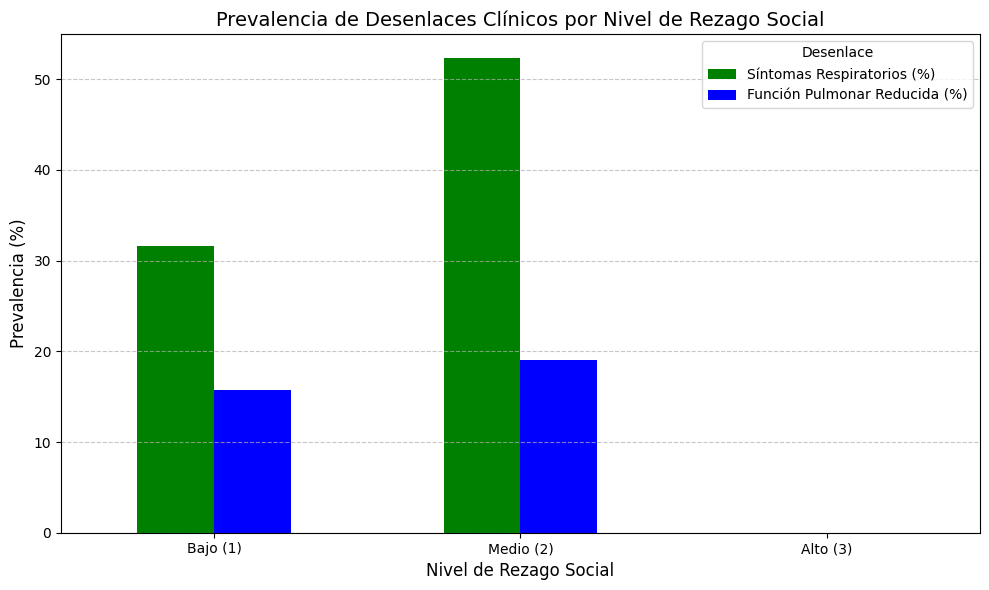

In [ ]:
# ==============================================================================
# 5. GRÁFICOS PARA EL CARTEL
# ==============================================================================

# ==============================================================================
# APARTADO DE DEFINICIÓN DE VARIABLES COMPUESTAS/ANALÍTICAS (CORRECCIÓN)
# ==============================================================================
EXPOSURE_IVS = 'IVS_codificado'
EXPOSURE_AÑOS = 'años_trabajando'
OUTCOME_SINTOMAS = 'sintomas'
OUTCOME_ESPIRO = 'espirometria_reducida'
OUTCOME_VARS = [OUTCOME_SINTOMAS, OUTCOME_ESPIRO] # Lista de desenlaces para bucles y gráficos

# Crear el DataFrame limpio final para el análisis bivariado
df = df.dropna(subset=[EXPOSURE_IVS, EXPOSURE_AÑOS, OUTCOME_SINTOMAS, OUTCOME_ESPIRO]).copy()
print(f"--- Análisis listo para N={len(df)} sujetos ---")

# --- 4. GRÁFICO DE BARRAS DOBLES (PREVALENCIA POR REZAGO) ---
print("\n--- 4. GRÁFICA DE BARRAS DOBLES (PREVALENCIA DE SÍNTOMAS/ESPIRO) ---")

# Usamos la clasificación generada (1, 2, 3)
df_graph1 = df.groupby(EXPOSURE_IVS)[OUTCOME_VARS].mean() * 100
df_graph1.columns = ['Síntomas Respiratorios (%)', 'Función Pulmonar Reducida (%)']

plt.figure(figsize=(10, 6))
df_graph1.plot(kind='bar', color= ('green', 'blue'), rot=0, ax=plt.gca())
plt.title('Prevalencia de Desenlaces Clínicos por Nivel de Rezago Social', fontsize=14)
plt.xlabel('Nivel de Rezago Social', fontsize=12)
plt.ylabel('Prevalencia (%)', fontsize=12)
plt.legend(title='Desenlace')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=[0, 1, 2], labels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.tight_layout()
plt.show()


--- 6. GRÁFICO DE TENDENCIA (AÑOS TRABAJANDO vs PROBABILIDAD DE SÍNTOMAS) ---


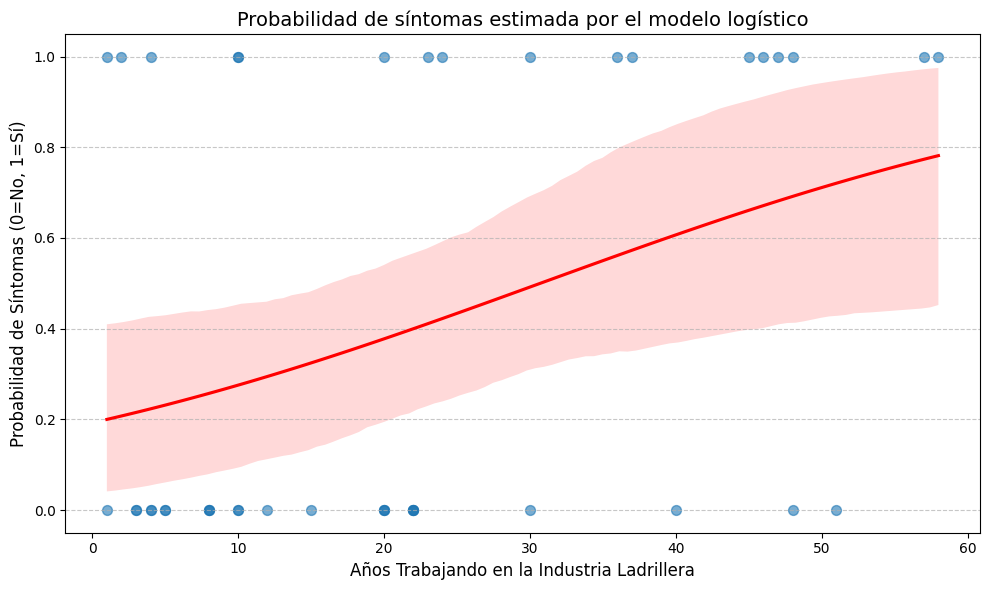

In [ ]:
print("\n--- 6. GRÁFICO DE TENDENCIA (AÑOS TRABAJANDO vs PROBABILIDAD DE SÍNTOMAS) ---")

plt.figure(figsize=(10, 6))

# Usamos la regresión logística (Regresión Logística Simple) para trazar la línea de tendencia
sns.regplot(
    data=df, # Changed from df_analisis to df
    x=EXPOSURE_AÑOS,
    y=OUTCOME_SINTOMAS,
    logistic=True, # Traza la línea de regresión logística (tendencia de probabilidad)
    scatter_kws={'alpha': 0.6, 's': 50}, # Puntos de dispersión (Sintomas 0 o 1)
    line_kws={'color': 'red'},
    ax=plt.gca()
)

plt.title(f'Probabilidad de síntomas estimada por el modelo logístico', fontsize=14) # Removed (OR={or_val:.3f})
plt.xlabel('Años Trabajando en la Industria Ladrillera', fontsize=12)
plt.ylabel('Probabilidad de Síntomas (0=No, 1=Sí)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# 3. CÁLCULO DE OR PARA AÑOS TRABAJANDO (HALLAZGO SIGNIFICATIVO p=0.03)
# ==============================================================================

print("\n--- 2. OR Y IC95% PARA AÑOS TRABAJANDO vs. SÍNTOMAS ---")

# Import statsmodels
import statsmodels.api as sm
import numpy as np

# La Regresión Logística Simple se utiliza para calcular el OR por cada unidad de cambio (año)
Y = df[OUTCOME_SINTOMAS]
X = df[EXPOSURE_AÑOS]

# Añadir la constante
X = sm.add_constant(X, prepend=False)

# Ejecutar el modelo Logit
try:
    model = sm.Logit(Y, X).fit(disp=False)

    # Extraer el OR y el IC95% (exponencial del coeficiente)
    or_val = np.exp(model.params[EXPOSURE_AÑOS])
    conf_int = np.exp(model.conf_int().loc[EXPOSURE_AÑOS])
    p_log = model.pvalues[EXPOSURE_AÑOS]

    print(f"OR por cada AÑO trabajado: {or_val:.3f}")
    print(f"IC 95%: [{conf_int[0]:.3f}, {conf_int[1]:.3f}]")
    print(f"Valor p (Logit/Wald): {p_log:.4f}")

except Exception as e:
    print(f"ERROR: Fallo en Regresión Logística. {e}")


--- 2. OR Y IC95% PARA AÑOS TRABAJANDO vs. SÍNTOMAS ---
OR por cada AÑO trabajado: 1.048
IC 95%: [1.006, 1.091]
Valor p (Logit/Wald): 0.0237



--- NOTA ---
La tabla interactiva de Plotly se ha generado arriba. Para el cartel, se debe capturar como imagen.
El fondo es transparente y los colores de relleno han sido eliminados.
